In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import pandas as pd
import numpy as np

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios,
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging,
                            path_CLUSTER_results,
                            file_tas
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.signal import detrend

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

## Load Data

a. GDP Data

In [5]:
gdp_dfs = [pd.read_csv(cset.path_INTERIM_GDP/ file_name) for file_name in cset.GDP_interim_dataset_names]

## Clustering Analysis

In [6]:
# --- Parameters ---
n_scenarios, n_isos, n_runs, n_time_steps = 10, 157, 100, 86
n_clusters = 20
colors = sns.color_palette('viridis', n_clusters)
output_path = Path(cset.path_GRAPHICS) / 'appendix'
output_path.mkdir(parents=True, exist_ok=True)

In [7]:
def cluster_growth_trajectories(gdp_df): 
    # --- Prepare GDP data ---
    pivot = gdp_df.sort_values(by=['scen', 'iso', 'run', 'year']).pivot_table(index=['scen', 'iso', 'run'], columns='year', values='SSP2_clim')

    # --- Reshape and standardize ---
    gdp_array = pivot.values.reshape(n_scenarios, n_isos, n_runs, n_time_steps)
    gdp_std = StandardScaler().fit_transform(gdp_array.reshape(-1, n_time_steps).T)

    # --- KMeans clustering ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(gdp_std.T)

    # --- Plot clusters ---
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(4, 5, figsize=(18, 14))
        for i, ax in enumerate(axes.flatten()):
            cluster_mask = labels == i
            ax.plot(gdp_std[:, cluster_mask], color=colors[i], alpha=0.1)
            ax.plot(gdp_std[:, cluster_mask].mean(axis=1), color='black', linewidth=2)

            ax.set_title(f'Cluster {i + 1}', fontsize=labelsize_large)

            if i % 5 == 0:
                ax.set_ylabel('Standardized GDP per capita', fontsize=labelsize_medium)
            ax.set_yticks([-2, 0, 2])
            ax.set_yticklabels([-2, 0, 2], fontsize=labelsize_medium)

            if i >= 15:
                ax.set_xlabel('Years', fontsize=labelsize_medium)
                ax.set_xticks([0, 35, 60, 85])
                ax.set_xticklabels([2015, 2050, 2075, 2100], fontsize=labelsize_medium)
            else:
                ax.set_xticks([0, 35, 60, 85])
                ax.set_xticklabels([])

        plt.tight_layout()
        plt.savefig(output_path / 'gdp_clusters.png', dpi=600)
        plt.show()
    return()

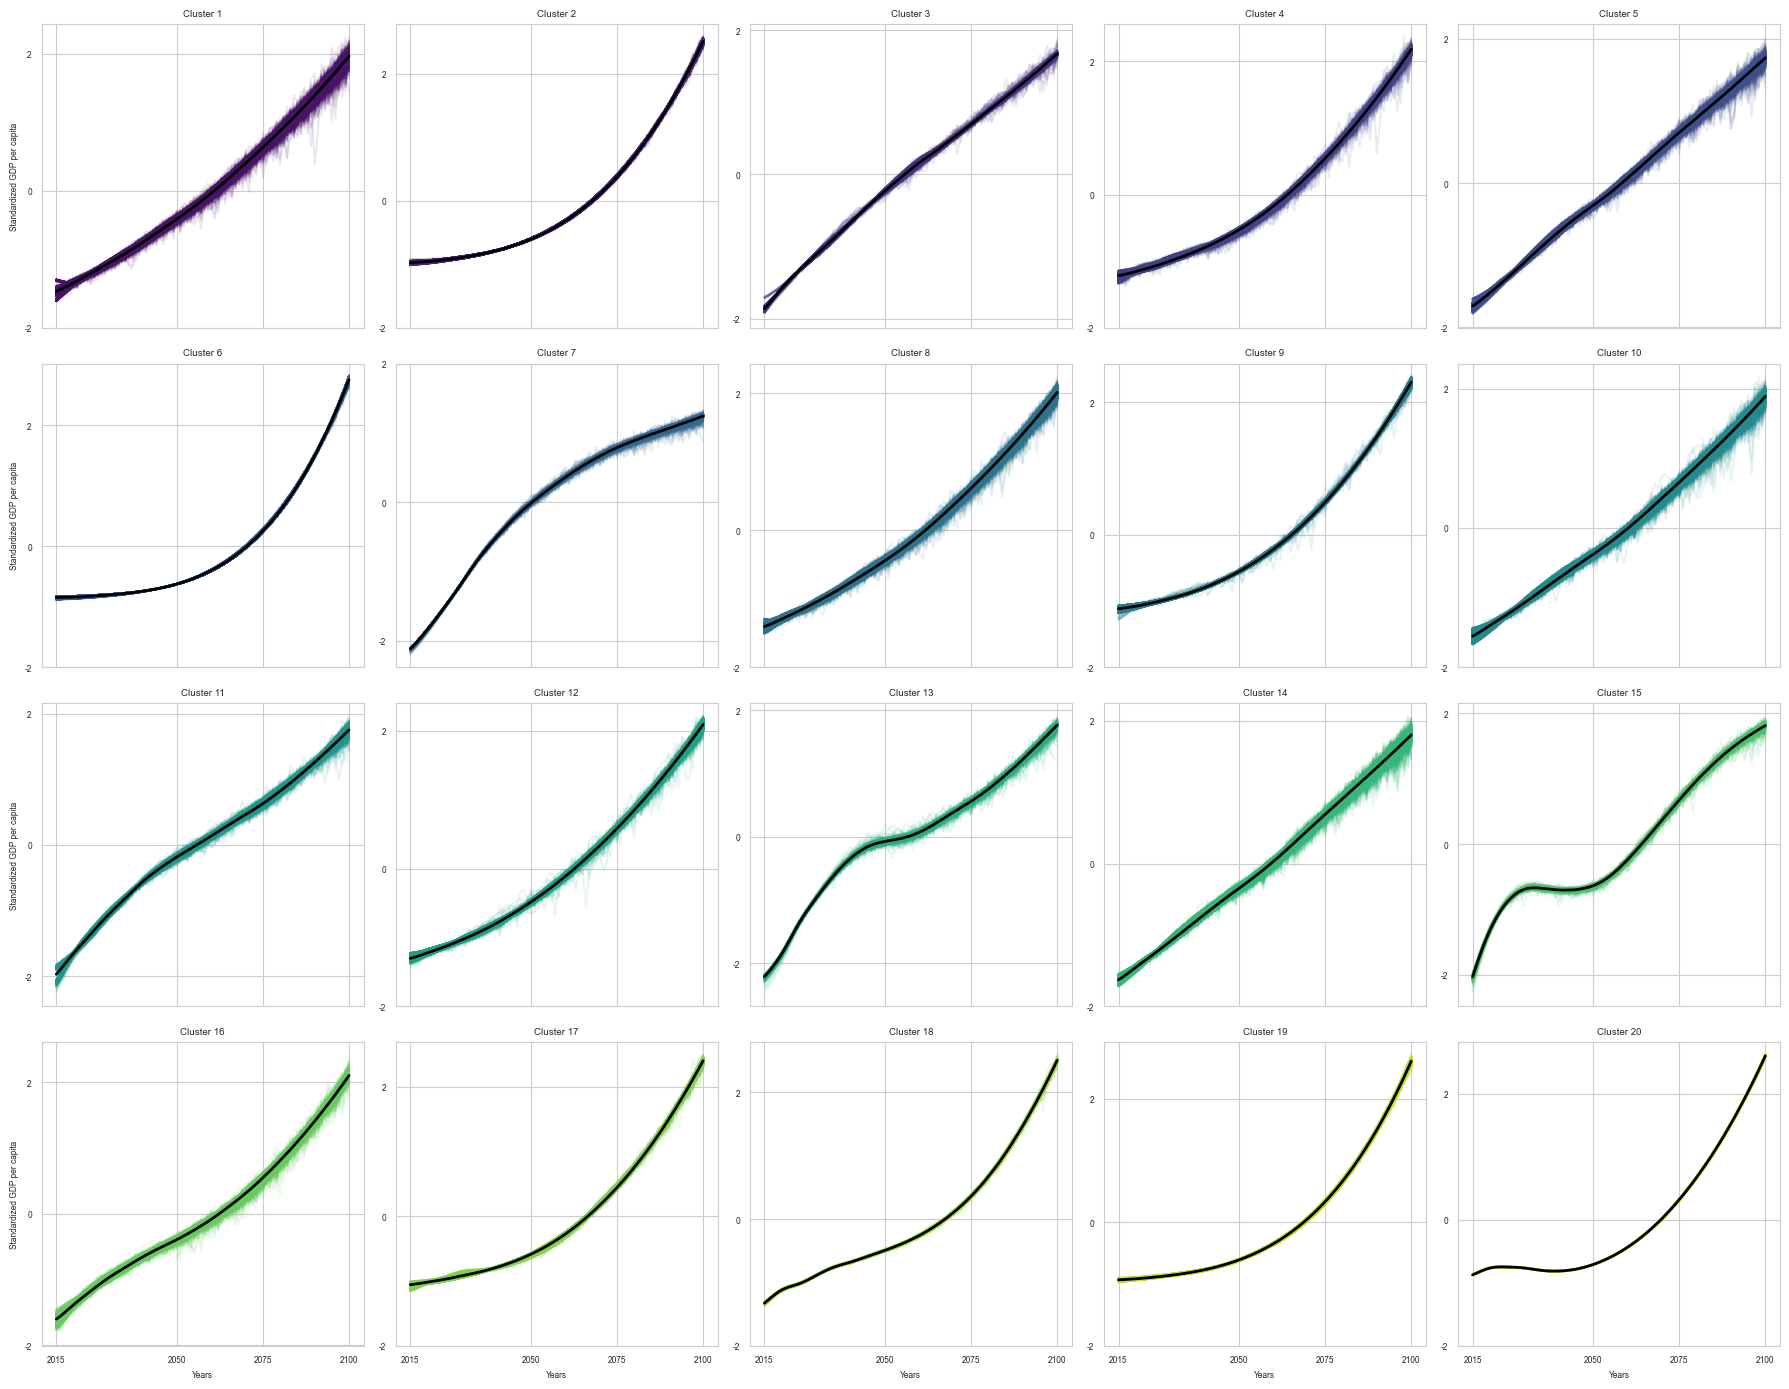

()

In [8]:
cluster_growth_trajectories(gdp_dfs[0])

## Devision into growth categories

- categories: growth, stagnating growth, growth reversal, inconclusive 
- assign every trajectory a lable 

In [9]:
# --- Parameters ---
n_scenarios, n_isos, n_runs, n_time_steps = 10, 157, 100, 86
window_size = 5
tol = 0.005

colors_clusters = ['#7A9A7A', 'orange', '#7A5DAB']
cluster_labels = ['Growth', 'Stagnation', 'Decline']

# --- Rolling mean along axis 1 ---
def rolling_mean_2d(arr, window):
    kernel = np.ones(window) / window
    return np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=arr)

# --- Classify trajectories ---
def classify_growth_trajectories(gdp_dfs):
    classification_dfs = []

    for gdp_df in gdp_dfs:
        # Prepare data
        gdp_df = gdp_df.sort_values(by=['scen', 'iso', 'run', 'year'])
        pivot = gdp_df.pivot_table(index=['scen', 'iso', 'run'], columns='year', values='SSP2_clim')
        gdp_array = pivot.values.reshape(n_scenarios, n_isos, n_runs, n_time_steps)

        # Standardize and smooth
        gdp_std = StandardScaler().fit_transform(gdp_array.reshape(-1, n_time_steps).T)
        gdp_smooth = rolling_mean_2d(gdp_std.T, window_size).T[2:-2, :]

        # Classify
        final = gdp_smooth[-1]
        peak = np.max(gdp_smooth[:-2], axis=0)
        conditions = [
            final > (1 + tol) * peak,
            (final > peak) & (final <= (1 + tol) * peak),
            final <= peak
        ]
        choices = ['growth', 'stagnation', 'nogrowth']
        categories = np.select(conditions, choices, default='empty')

        # Store classification
        tmp = pivot.reset_index()[['scen', 'iso', 'run']]
        classification_df = tmp.copy()
        classification_df['category'] = categories
        classification_dfs.append(classification_df)

        # Plot
        with sns.axes_style('whitegrid'):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i, (label, color) in enumerate(zip(cluster_labels, colors_clusters)):
                idx = np.where(categories == choices[i])[0][:400]
                axes[i].plot(gdp_smooth[:, idx], color=color, alpha=0.1)
                axes[i].set_title(label, fontsize=labelsize_large)
                axes[i].set_xticks([0, 35, 60, 83], [2015, 2050, 2075, 2100], fontsize=labelsize_medium)
                axes[i].set_yticks([-2, 0, 2], [-2, 0, 2], fontsize=labelsize_medium)
                axes[i].set_ylim(-2.5, 2.5)
                axes[i].set_xlabel('Year', fontsize=labelsize_medium)
                if i == 0:
                    axes[i].set_ylabel('Standardized GDP per capita', fontsize=labelsize_medium)
            fig.tight_layout()
            plt.show()

    return classification_dfs

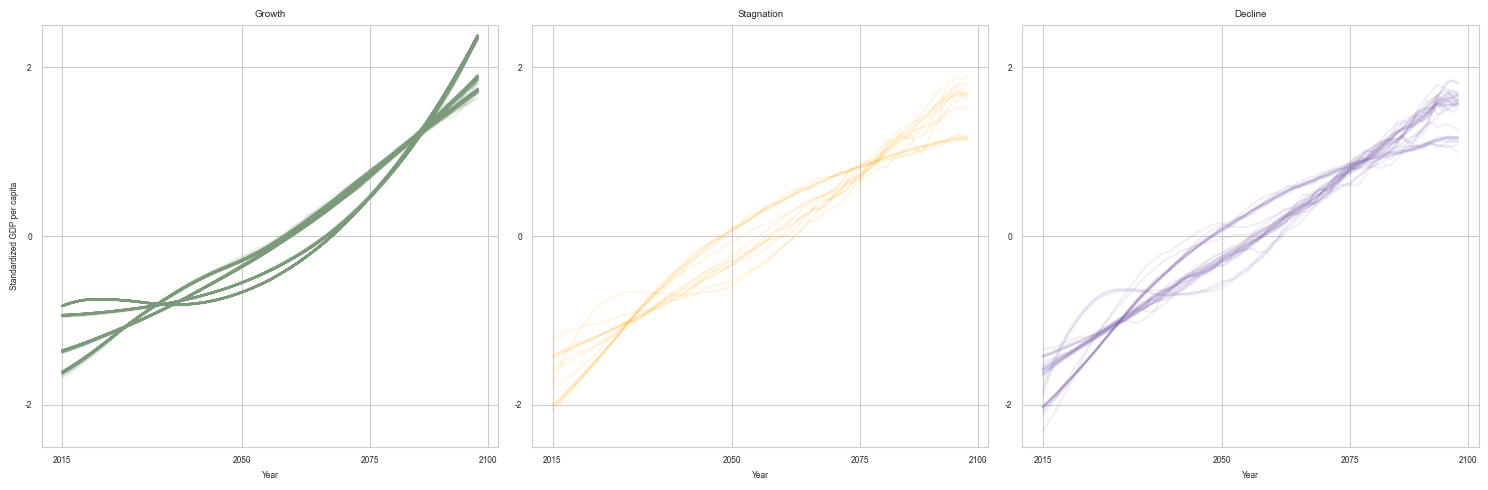

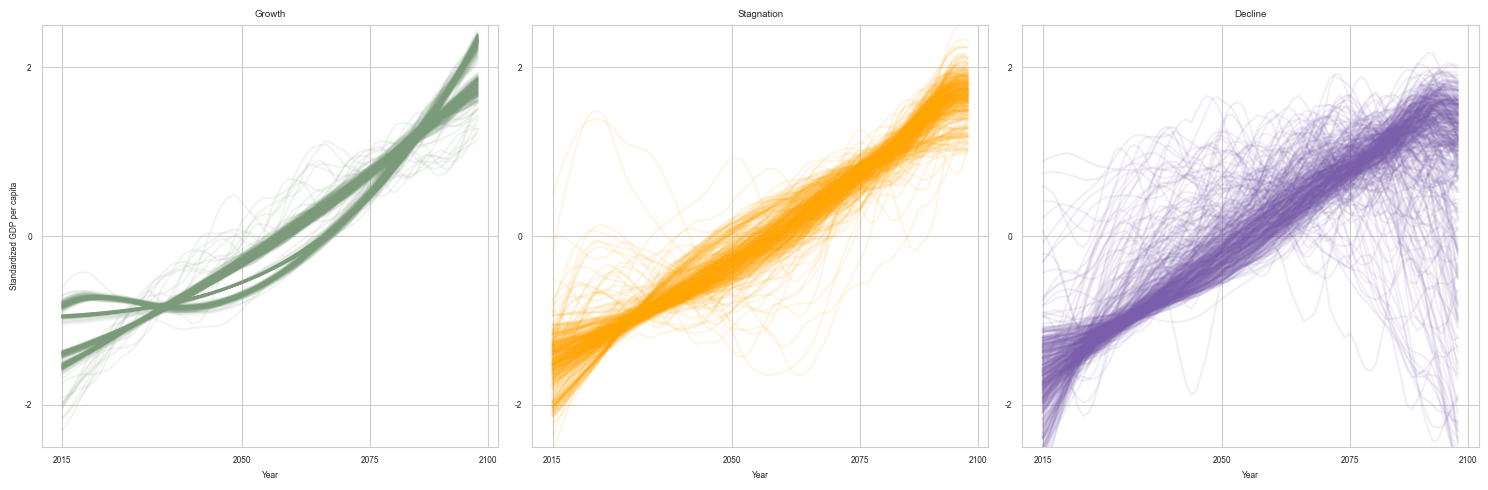

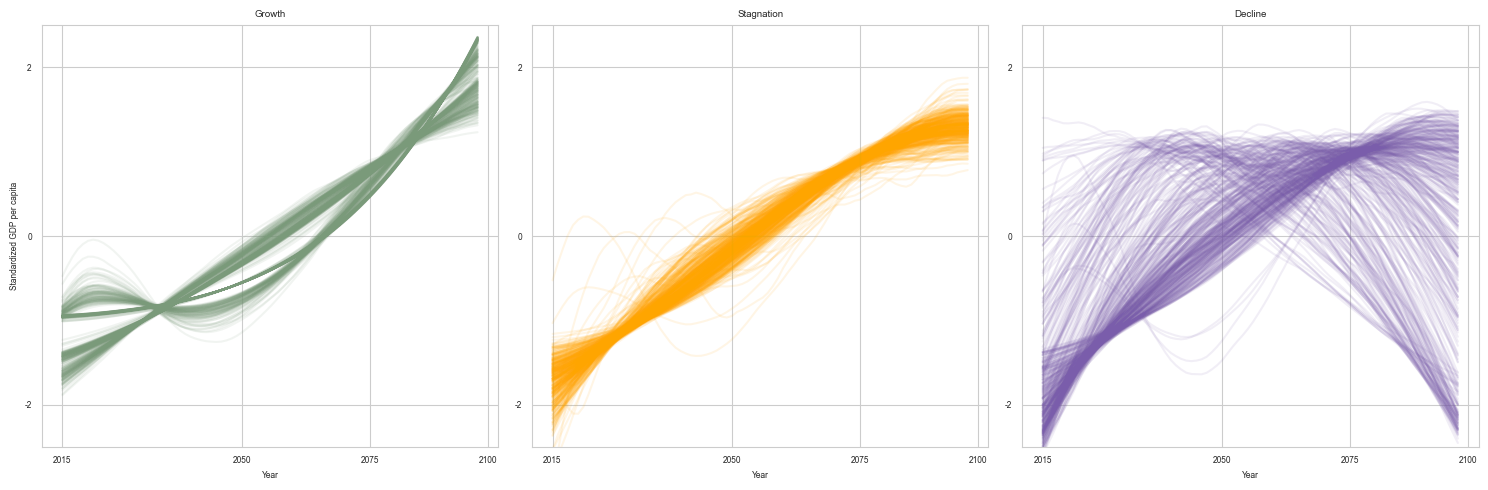

In [10]:
classification_dfs = classify_growth_trajectories(gdp_dfs)

# (1) store classification results 
for classification_df, file_name in zip(classification_dfs, cset.GDP_interim_dataset_names):
    classification_df.to_csv(cset.path_CLUSTER_results / f'Classification_{file_name}', index=False)